In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------

In [2]:
# Data extracted from Fig. 3a in Jensen et al. (2005)
jensen2005 = dict()
jensen2005['E125'] = dict()
jensen2005['E500'] = dict()

# Axons
jensen2005['E125']['axon'] = dict()
jensen2005['E125']['axon']['h25'] = np.array([0.10000, 2.99614, 0.19835, 1.59634, 0.49824,
                                   0.72339, 1.00000, 0.54247, 2.00708, 0.48697,
                                   5.04155, 0.46555, 10.00000, 0.46976, 20.30918,
                                   0.46976, 50.41550, 0.46555]).reshape((-1, 2))
jensen2005['E125']['axon']['h25'][:, 0] /= 1000.0  # convert ms to s

jensen2005['E500']['axon'] = dict()
jensen2005['E500']['axon']['h25'] = np.array([0.09883, 20.86371, 0.19535, 8.69288, 0.48840,
                                   4.50809, 0.98832, 2.93549, 1.90815, 2.31750,
                                   4.88400, 2.19890, 9.54095, 2.08637, 19.08149,
                                   2.06818, 47.70583, 1.99701]).reshape((-1, 2))
jensen2005['E500']['axon']['h25'][:, 0] /= 1000.0  # from ms to s


# SL responses: typically a single action potential, although a few cells elicited
# a second action potential that immediately followed the first.
jensen2005['E125']['SL'] = dict()
jensen2005['E125']['SL']['h25'] = np.array([0.10239, 0.74318, 0.19372, 0.62082, 0.49824,
                                 0.46976, 1.00000, 0.37855, 1.96023, 0.39954,
                                 5.04155, 0.40679, 10.00000, 0.39954, 19.83517,
                                 0.39242, 49.82369, 0.35866]).reshape((-1, 2))
jensen2005['E125']['SL']['h25'][:, 0] /= 1000.0  # from ms to s

jensen2005['E500']['SL'] = dict()
jensen2005['E500']['SL']['h25'] = np.array([0.09883, 6.86281, 0.20000, 4.50809, 0.47706,
                                 2.83447, 0.98832, 2.01457, 1.93070, 2.05016,
                                 4.77058, 1.99701, 9.54095, 2.01457, 19.08149,
                                 1.97960, 47.14866, 1.87830]).reshape((-1, 2))
jensen2005['E500']['SL']['h25'][:, 0] /= 1000.0  # from ms to s

In [3]:
# Data extracted from Fig. 4 in Jensen et al. (2005)

# Cathodic
jensen2005['E125']['cathodic'] = np.array([0.09790, 3.60377, 0.19721, 1.80616, 0.50172,
                                       0.83488, 0.98945, 0.65090, 1.99315, 0.60031,
                                       4.96424, 0.58921, 9.89445, 0.58921, 20.14408,
                                       0.58555, 51.24806, 0.58555]).reshape((-1, 2))
jensen2005['E125']['cathodic'][:, 0] /= 1000

jensen2005['E500']['cathodic'] = np.array([0.09674, 12.99098, 0.19533, 7.89559, 0.49841,
                                       4.14732, 0.98500, 2.61376, 1.98677, 1.97357,
                                       4.94956, 1.87169, 9.86591, 1.84259, 19.66889,
                                       1.74952, 48.99084, 1.73072]).reshape((-1, 2))
jensen2005['E500']['cathodic'][:, 0] /= 1000



# Anodic
jensen2005['E125']['anodic'] = np.array([0.10000, 8.94028, 0.19931, 5.57116, 0.50172,
                                     3.83516, 1.01067, 3.42874, 2.03590, 3.10379,
                                     5.01719, 3.14266, 10.21449, 3.12316, 20.35897,
                                     3.06540, 51.24806, 3.18202]).reshape((-1, 2))
jensen2005['E125']['anodic'][:, 0] /= 1000

jensen2005['E500']['anodic'] = np.array([0.09849, 26.77548, 0.19485, 13.42013, 0.49741, 6.40109, 0.98211, 4.95176,
                              1.93901, 3.87704, 4.93281, 3.90493, 9.83307, 3.79816, 20.02002, 3.76131,
                              50.94491, 3.56675]).reshape((-1, 2))
jensen2005['E500']['anodic'][:, 0] /= 1000

In [4]:
# Figure 5

# Axons
jensen2005['E125']['axon']['p0.1'] = np.array([0, 3.49149, 49.49211, 4.93797, 99.58362,
                                          9.51688, 149.75063, 12.19050,  198.90872,
                                          36.68733, 299.46237, 183.41754, 398.49234,
                                          349.14896]).reshape((-1, 2))
jensen2005['E125']['axon']['p1.0'] = np.array([0, 0.69783, 49.57602, 1.07461, 99.40599,
                                          2.77146, 149.33927, 4.01945, 199.13481,
                                          12.55909, 299.34143, 39.71534, 398.80122,
                                          80.58422]).reshape((-1, 2))
jensen2005['E125']['axon']['p10.0'] = np.array([0, 0.69251, 48.94730, 1.00000, 98.98513,
                                           2.56788, 149.53263, 3.99084, 198.69358,
                                           12.77565, 298.90724, 39.42255, 399.21882,
                                           70.96821]).reshape((-1, 2))

jensen2005['E500']['axon']['p0.1'] = np.array([0, 14.34171, 48.75000, 24.59424, 99.58333,
                                          49.36522, 148.33333, 100.31863, 198.75000,
                                          187.24588, 298.75000, 351.63856, 397.91667,
                                          459.12382]).reshape((-1, 2))
jensen2005['E500']['axon']['p1.0'] = np.array([0, 2.79305, 49.56506, 3.45266, 98.39239,
                                          6.93181, 147.97507, 21.78898, 198.56416,
                                          26.93464, 298.41882, 59.93593, 398.31972,
                                          103.40334]).reshape((-1, 2))
jensen2005['E500']['axon']['p10.0'] = np.array([0, 2.21828, 49.01961, 2.37154, 98.47063,
                                           5.18242, 147.91303, 11.88743, 197.81488,
                                           20.63321, 296.86145, 43.74543, 396.36101,
                                           72.77994]).reshape((-1, 2))

jensen2005['E125']['SL']['p0.1'] = np.array([0, 0.77518, 48.38813, 4.97207, 98.86690,
                                        10.42399, 148.14874, 25.75066, 196.50495,
                                        42.85309, 296.74433, 82.74288, 395.96234,
                                        131.10489]).reshape((-1, 2))
jensen2005['E125']['SL']['p1.0'] = np.array([0, 0.40849, 47.46181, 1.09473, 98.31536,
                                        3.22338, 148.30039, 5.91579, 197.87361,
                                        8.17544, 297.61156, 14.20009, 397.89608,
                                        24.65805]).reshape((-1, 2))
jensen2005['E125']['SL']['p10.0'] = np.array([0, 0.36592, 49.45055, 1.23467, 98.90110,
                                         2.91601, 149.45055, 5.95179, 198.35165,
                                         7.23028, 299.45055, 14.28662, 398.90110,
                                         29.16008]).reshape((-1, 2))

jensen2005['E500']['SL']['p0.1'] = np.array([0, 8.52228, 50.82873, 13.76857, 101.65746,
                                        25.28004, 148.61878, 32.13249, 200.00000,
                                        34.80701, 301.10497, 65.98488, 400.00000,
                                        121.15277]).reshape((-1, 2))
jensen2005['E500']['SL']['p1.0'] = np.array([0, 2.88451, 47.17229, 3.58008, 96.92153,
                                        6.01963, 146.76337, 8.35448, 197.77023,
                                        10.36906, 297.88597, 25.79769, 399.35962,
                                        38.48525]).reshape((-1, 2))
jensen2005['E500']['SL']['p10.0'] = np.array([0, 3.00428, 50.00000, 3.71647, 100.54348,
                                         5.05424, 150.00000, 6.87471, 198.91304,
                                         10.27984, 300.00000, 13.86912, 400.00000,
                                         37.45896]).reshape((-1, 2))

Helper
------

In [5]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.
    if np.allclose(y.ptp(), 0.0, atol=1e-12):
        return np.inf

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [6]:
# Monophasic pulse train
def get_jensen2005_pt(ptype, freq, amp, pdur, stim_dur, tsample=0.005 / 1000):
    assert freq >= 0
    assert amp >= 0  # sign handled by mono pulse
    assert pdur > 0
    assert stim_dur >= 0
    
    delay_dur = 10.0 / 1000
    
    stim_size = int(round(stim_dur / tsample))
    if np.isclose(amp, 0.0) or np.isclose(freq, 0.0):
        return utils.TimeSeries(tsample, np.zeros(stim_size))
    
    envelope_dur = 1.0 / float(freq)
    assert envelope_dur > delay_dur
    num_envelopes = np.maximum(1, int(np.ceil(stim_dur * freq)))
    
    pulse_train = np.array([])
    for j in range(num_envelopes):
        # A single mono pulse
        pulse = e2cm.get_monophasic_pulse(ptype, pdur, tsample, delay_dur, envelope_dur) * amp
        pulse_train = np.concatenate((pulse_train, pulse), axis=0)
    pulse_train = pulse_train[:stim_size]
    assert not np.allclose(pulse_train, 0)
    
    return utils.TimeSeries(tsample, pulse_train)

# Fit
----------

In [7]:
def run_jensen2005_fig3(model, rtype, pdurs, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
        gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=model['height'])
        resp.append(gcr.r_lin.max())

    fig3['resp'] = np.array(resp)
    return fig3

In [8]:
def run_jensen2005_fig4(model, ptype, pdurs, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pdurs
    
    resp = []
    for pd, amp in zip(pdurs, amps):
        stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
        gcr.model_cascade(stim, isaxon=True, radius=model['diam'] / 2.0, height=model['height'])
        resp.append(gcr.r_lin.max())

    fig4['resp'] = np.array(resp)
    return fig4

In [9]:
def run_jensen2005_fig5(model, rtype, pdur, heights, amps):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig5 = dict()
    fig5['heights'] = heights
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    resp = []
    for ht, amp in zip(heights, amps):
        stim = get_jensen2005_pt('cathodic', stim_freq, amp, pdur, stim_dur, tsample)
        gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=ht)
        resp.append(gcr.r_lin.max())

    fig5['resp'] = np.array(resp)
    return fig5

In [10]:
def mse_jensen2005_fig3(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        model = get_model(x, diam, 25.0)
        for rtype in ['axon']:
            fig3 = run_jensen2005_fig3(model, rtype, jensen2005[ename][rtype]['h25'][:, 0],
                                      jensen2005[ename][rtype]['h25'][:, 1])
            mse += np.sum((fig3['resp'] - model['out_th']) ** 2)
    return mse

In [11]:
def mse_jensen2005_fig4(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        for ptype in ['cathodic', 'anodic']:
            model = get_model(x, diam, 25.0)
            fig4 = run_jensen2005_fig4(model, ptype, jensen2005[ename][ptype][:, 0],
                                      jensen2005[ename][ptype][:, 1])
            mse += np.sum((fig4['resp'] - model['out_th']) ** 2)
    return mse

In [12]:
def mse_jensen2005_fig5(x, jensen2005):
    mse = 0
    for diam in [125.0, 500.0]:
        ename = 'E%.0f' % diam
        model = get_model(x, diam, 25.0)
        for rtype in ['axon']:
            for pdur in [0.1, 1.0, 10.0]:
                ptype = 'p%.1f' % pdur
                fig5 = run_jensen2005_fig5(model, rtype, pdur / 1000.0,
                                           jensen2005[ename][rtype][ptype][:, 0],
                                           jensen2005[ename][rtype][ptype][:, 1])
                mse += np.sum((fig5['resp'] - model['out_th']) ** 2)
    return mse

In [13]:
def mse_all(x, jensen2005):
    mse = 0
    
    mse += mse_jensen2005_fig3(x, jensen2005)
    mse += mse_jensen2005_fig4(x, jensen2005)
    mse += mse_jensen2005_fig5(x, jensen2005)
    
    print('%s: %.11f' % (str([('%.8f' % xx) for xx in x]), mse))
    return mse

In [14]:
def get_model(x, diam, height):
    tsample = 0.005 / 1000

    [alpha, beta, gamma, delta, epsilon] = x
#     [alpha, beta] = [-1.17942333e-01,   1.85504592e+02]
    model = dict()
    model['diam'] = diam
    model['height'] = height
    
    model['gcr'] = ec2b.GanglionCell(tsample, ca_scale=0,
                                     inl_scale=0,
                                     alpha=alpha,
                                     beta=beta,
                                     gamma=gamma,
                                     delta=delta,
                                     epsilon=epsilon,
#                                      zeta=zeta,
                                     anodic_scale=0.214,
                                     axon_scale=0.533)
    
    model['out_th'] = 1.0
    
    return model

In [15]:
res = minimize(mse_all, [1.0, 1.0, 1.0, 1.0, 1.0], args=(jensen2005),
               method='L-BFGS-B', bounds=[(-1e5, 1e5), (0, 1e5), (0, 1e5), (1e-5, 1e5), (-1e5, 1e5)])

['1.00000000', '1.00000000', '1.00000000', '1.00000000', '1.00000000']: 2542046160.41249990463
['1.00000001', '1.00000000', '1.00000000', '1.00000000', '1.00000000']: 2542046160.41829586029
['1.00000000', '1.00000001', '1.00000000', '1.00000000', '1.00000000']: 2542046160.41361999512
['1.00000000', '1.00000000', '1.00000001', '1.00000000', '1.00000000']: 2542046161.48824167252
['1.00000000', '1.00000000', '1.00000000', '1.00000001', '1.00000000']: 2542046210.04164886475
['1.00000000', '1.00000000', '1.00000000', '1.00000000', '1.00000001']: 2542046160.54503917694
['-100000.00000000', '0.00000000', '0.00000000', '0.00001000', '-100000.00000000']: 13199825419465.09375000000
['-99999.99999999', '0.00000000', '0.00000000', '0.00001000', '-100000.00000000']: 13199825419464.76171875000
['-100000.00000000', '0.00000001', '0.00000000', '0.00001000', '-100000.00000000']: 13199825419465.07226562500
['-100000.00000000', '0.00000000', '0.00000001', '0.00001000', '-100000.00000000']: 13199825419428

# Plot
----------

In [16]:
print(res.x)

[ -6.59132537e-01   9.89468235e-01   1.85303782e-03   4.57722526e-04
  -2.74419027e-01]


In [17]:
mse_jensen2005_fig3(res.x, jensen2005)

13.498416600582583

In [18]:
mse_jensen2005_fig4(res.x, jensen2005)

18.708245915638688

In [19]:
mse_jensen2005_fig5(res.x, jensen2005)

16.277988235484109

In [20]:
def run_jensen2005_fig3_findamp(model, rtype, pdurs):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig3 = dict()
    fig3['pulse_durs'] = pdurs
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    amp_match = []
    for pd in pdurs:
        # For every pulse duration, we need to find the current that gives
        # output == 1. Since output is linear, 2-3 data points should suffice
        # for intra/extrapolation. We also want "plausible" mA currents as
        # input:
        amp_search = [0.1, 1.0, 100.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt('cathodic', stim_freq, amp, pd, stim_dur, tsample)
            gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=model['height'])
            resp_search.append(gcr.r_lin.max())
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))

    fig3['amp_match'] = np.array(amp_match)
    return fig3

In [21]:
def run_jensen2005_fig4_findamp(model, ptype, pdurs):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig4 = dict()
    fig4['pulse_durs'] = pdurs
    
    amp_match = []
    for pd in pdurs:
        # For every pulse duration, we need to find the current that gives
        # output == 1. Since output is linear, 2-3 data points should suffice
        # for intra/extrapolation. We also want "plausible" mA currents as
        # input:
        amp_search = [0.1, 1.0, 100.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt(ptype, stim_freq, amp, pd, stim_dur, tsample)
            gcr.model_cascade(stim, isaxon=True, radius=model['diam'] / 2.0, height=model['height'])
            resp_search.append(gcr.r_lin.max())
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))
        
    fig4['amp_match'] = np.array(amp_match)
    return fig4

In [22]:
def run_jensen2005_fig5_findamp(model, rtype, pdur, heights):
    # max pulse dur is 100ms
    stim_dur = 0.2
    
    # just one pulse, so we don't need charge accumulation
    stim_freq = 1.0
    
    gcr = model['gcr']
    tsample = gcr.tsample
    
    fig5 = dict()
    fig5['heights'] = heights
    
    if rtype == 'axon':
        isaxon = True
    else:
        isaxon = False
    
    amp_match = []
    for ht in heights:
        amp_search = [0.1, 1.0, 100.0, 1000.0]
        resp_search = []
        for amp in amp_search:
            stim = get_jensen2005_pt('cathodic', stim_freq, amp, pdur, stim_dur, tsample)
            gcr.model_cascade(stim, isaxon=isaxon, radius=model['diam'] / 2.0, height=ht)
            resp_search.append(gcr.r_lin.max())
        amp_match.append(fit_amps(amp_search, resp_search, model['out_th']))

    fig5['amp_match'] = np.array(amp_match)
    return fig5

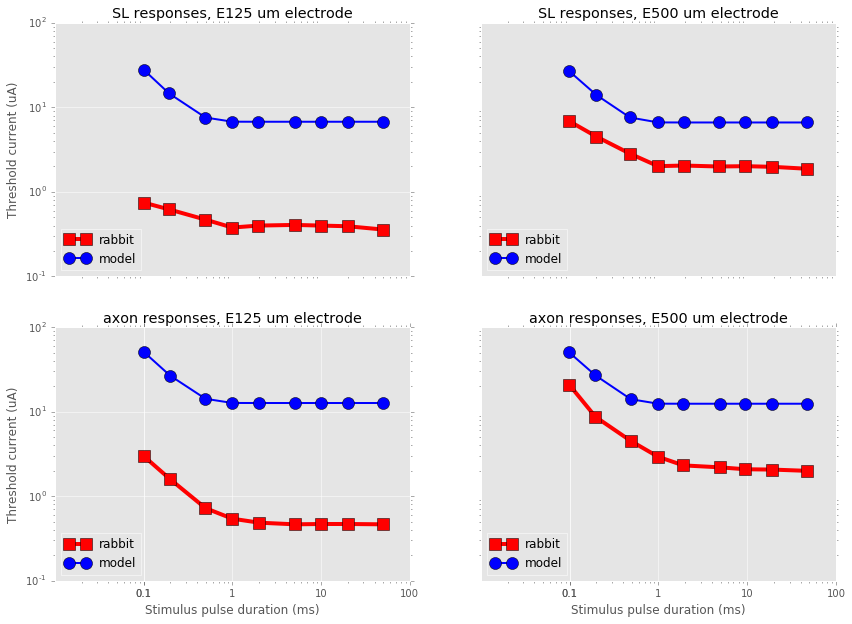

In [23]:
plt.figure(figsize=(14, 10))

subplot = 1
for rtype in ['SL', 'axon']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)
        plt.subplot(2, 2, subplot)
        
        fig3 = run_jensen2005_fig3_findamp(model, rtype, jensen2005[ename][rtype]['h25'][:, 0])

        plt.loglog(jensen2005[ename][rtype]['h25'][:, 0], jensen2005[ename][rtype]['h25'][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        plt.loglog(jensen2005[ename][rtype]['h25'][:, 0], fig3['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        
        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.1, 100)
        if subplot > 2:
            plt.xticks(np.array([0.1, 0.1, 1, 10, 100]) / 1000, [0.1, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.1, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('jensen2005_fig3.png')

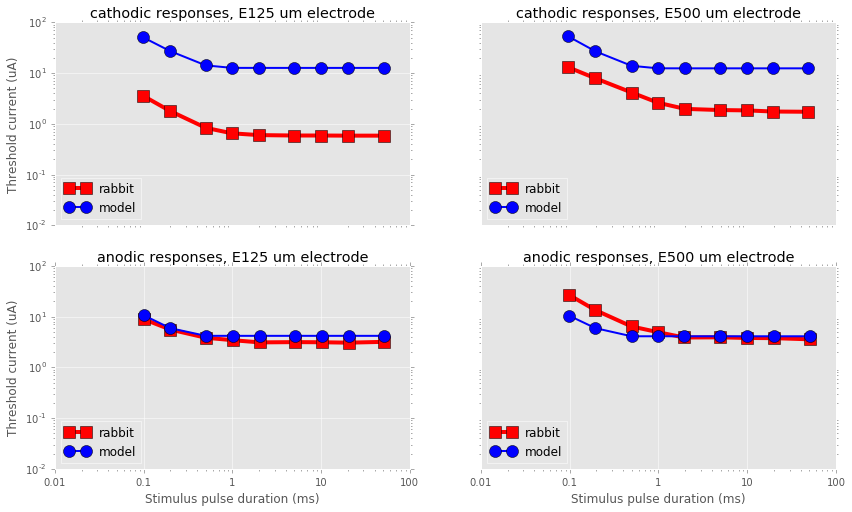

In [24]:
plt.figure(figsize=(14, 8))

subplot = 1
for ptype in ['cathodic', 'anodic']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)
        plt.subplot(2, 2, subplot)
        
        fig4 = run_jensen2005_fig4_findamp(model, ptype, jensen2005[ename][ptype][:, 0])
        plt.loglog(jensen2005[ename][ptype][:, 0], jensen2005[ename][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        plt.loglog(jensen2005[ename][ptype][:, 0], fig4['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')
        
        plt.title('%s responses, %s um electrode' % (ptype, ename))
        plt.legend(loc='lower left')
        plt.xlim(0.01 / 1000, 100.0 / 1000)
        plt.ylim(0.01, 100)
        if subplot > 2:
            plt.xticks(np.array([0.01, 0.1, 1, 10, 100]) / 1000, [0.01, 0.1, 1, 10, 100])
            plt.xlabel('Stimulus pulse duration (ms)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.01, 0.1, 1, 10, 100])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])
        
        subplot += 1
plt.savefig('jensen2005_fig4.png')

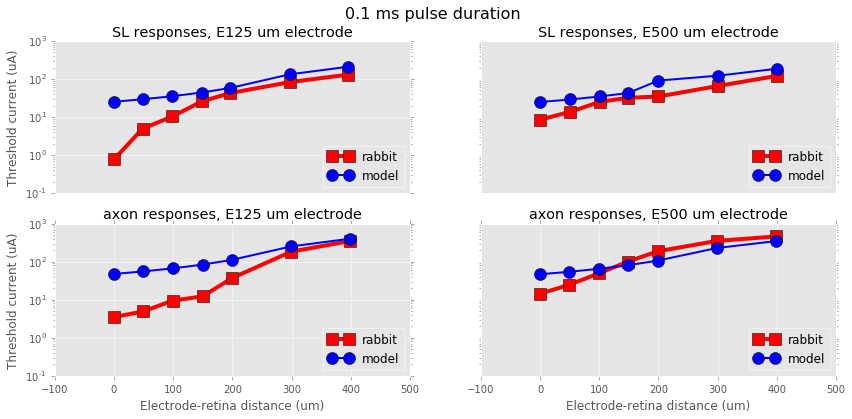

In [25]:
plt.figure(figsize=(14, 6))

subplot = 1
pdur = 0.1
ptype = 'p%.1f' % pdur
plt.suptitle('%.1f ms pulse duration' % pdur, fontsize=16)
for rtype in ['SL', 'axon']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)

        plt.subplot(2, 2, subplot)

        fig5 = run_jensen2005_fig5_findamp(model, rtype, pdur / 1000.0,
                                           jensen2005[ename][rtype][ptype][:, 0])

        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], jensen2005[ename][rtype][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], fig5['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')

        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower right')
        plt.xlim(-100, 500)
        plt.ylim(0.1, 1000)
        if subplot > 2:
            plt.xlabel('Electrode-retina distance (um)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])

        subplot += 1
plt.savefig('jensen2005_fig5_%s.png' % ptype)

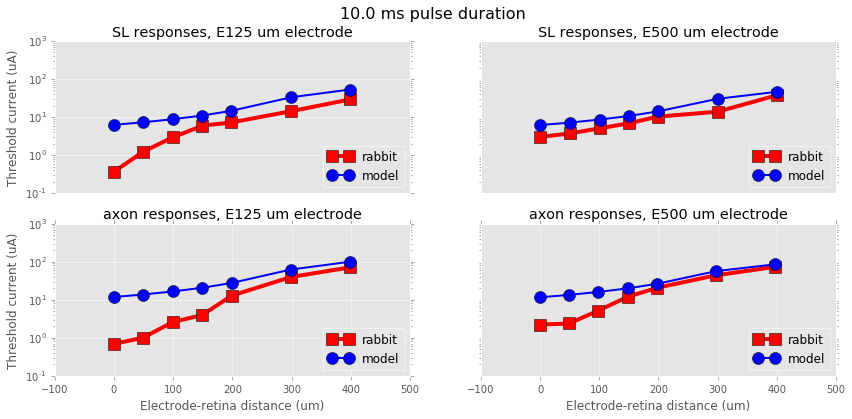

In [26]:
plt.figure(figsize=(14, 6))

subplot = 1
pdur = 10
ptype = 'p%.1f' % pdur
plt.suptitle('%.1f ms pulse duration' % pdur, fontsize=16)
for rtype in ['SL', 'axon']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)

        plt.subplot(2, 2, subplot)

        fig5 = run_jensen2005_fig5_findamp(model, rtype, pdur / 1000.0,
                                           jensen2005[ename][rtype][ptype][:, 0])

        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], jensen2005[ename][rtype][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], fig5['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')

        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower right')
        plt.xlim(-100, 500)
        plt.ylim(0.1, 1000)
        if subplot > 2:
            plt.xlabel('Electrode-retina distance (um)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])

        subplot += 1
plt.savefig('jensen2005_fig5_%s.png' % ptype)

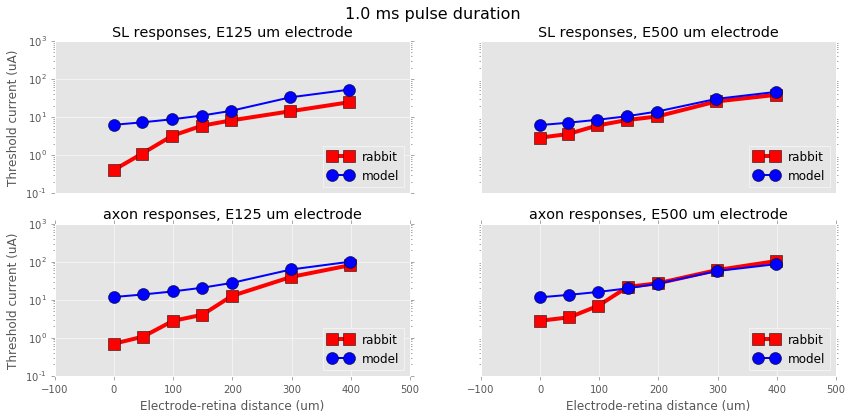

In [27]:
plt.figure(figsize=(14, 6))

subplot = 1
pdur = 1
ptype = 'p%.1f' % pdur
plt.suptitle('%.1f ms pulse duration' % pdur, fontsize=16)
for rtype in ['SL', 'axon']:
    for diam in [125, 500]:
        ename = 'E%.0f' % diam
        model = get_model(res.x, diam, 25.0)

        plt.subplot(2, 2, subplot)

        fig5 = run_jensen2005_fig5_findamp(model, rtype, pdur / 1000.0,
                                           jensen2005[ename][rtype][ptype][:, 0])

        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], jensen2005[ename][rtype][ptype][:, 1],
                   's-r', linewidth=4, markersize=12, label='rabbit')
        plt.semilogy(jensen2005[ename][rtype][ptype][:, 0], fig5['amp_match'],
                   'o-b', linewidth=2, markersize=12, label='model')

        plt.title('%s responses, %s um electrode' % (rtype, ename))
        plt.legend(loc='lower right')
        plt.xlim(-100, 500)
        plt.ylim(0.1, 1000)
        if subplot > 2:
            plt.xlabel('Electrode-retina distance (um)')
        else:
            plt.xticks([])
        if (subplot - 1) % 2 == 0:
            plt.yticks([0.1, 1, 10, 100, 1000])
            plt.ylabel('Threshold current (uA)')
        else:
            plt.yticks([])

        subplot += 1
plt.savefig('jensen2005_fig5_%s.png' % ptype)

((49, 10), (49, 10), (49, 10))


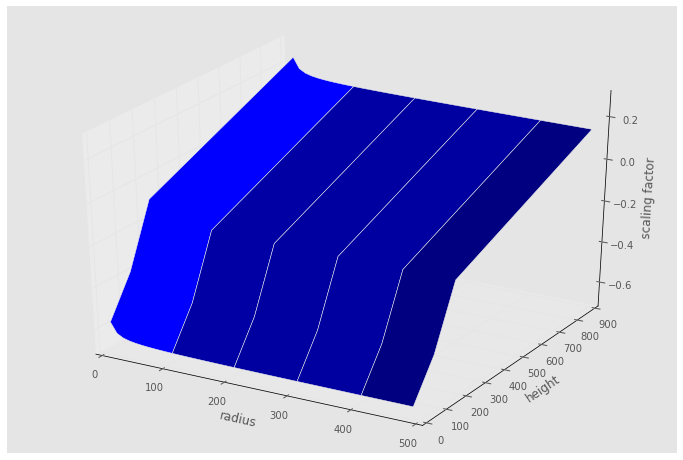

In [28]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')

R = np.arange(10, 500, 10)
H = np.arange(0, 1000, 100)
I = np.zeros((R.size, H.size))
for ri, rv in enumerate(R):
    for hi, hv in enumerate(H):
        I[ri, hi] = model['gcr'].effective_current(rv, hv)
H, R = np.meshgrid(H, R)
print((R.shape, H.shape, I.shape))

# Plot the surface.
surf = ax.plot_surface(R, H, I)
ax.set_xlabel('radius')
ax.set_ylabel('height')
ax.set_zlabel('scaling factor')
# ax.view_init(200, 60)

# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

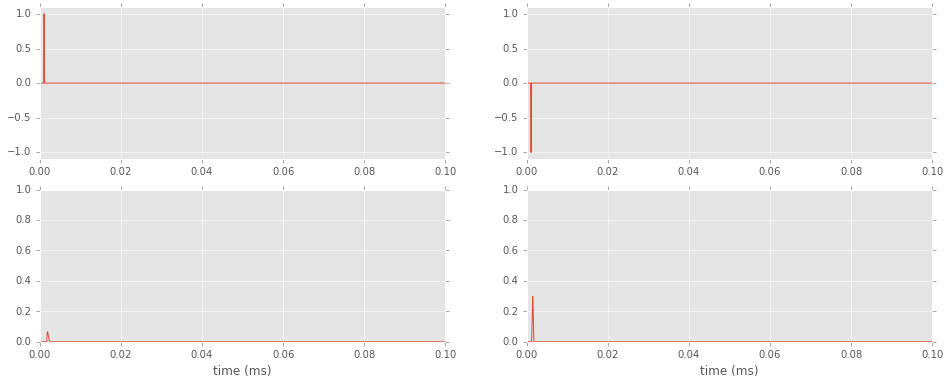

In [29]:
plt.figure(figsize=(16, 6))

dur = 0.1
delay = 1.0 / 1000
pdur = 0.2 / 1000

model = get_model(res.x, 40.0, 25.0)
gcr = model['gcr']
t = np.arange(0, dur, gcr.tsample)

for i, ptype in enumerate(['cathodic', 'anodic']):
    plt.subplot(2, 2, i + 1)
    pt = e2cm.get_monophasic_pulse(ptype, pdur, tsample=gcr.tsample, delay_dur=delay, stim_dur=dur)
    plt.plot(t, -pt)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    model['gcr'].model_cascade(utils.TimeSeries(gcr.tsample, pt), radius=model['diam'] / 2.0,
                               height=model['height'])

    plt.plot(t, np.maximum(0, gcr.r_lin))
    plt.xlabel('time (ms)')
    plt.ylim(0, 1.0)
plt.savefig('jensen2005_SL_monophasic.png')

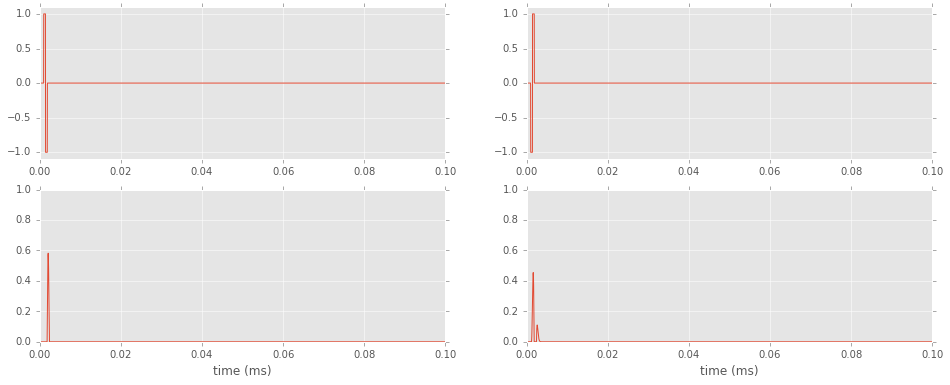

In [30]:
plt.figure(figsize=(16, 6))

gcr = model['gcr']

dur = 0.1
delay = 1.0 / 1000
pdur = 0.2 / 1000
idur = 0
t = np.arange(0, dur, gcr.tsample)

for i, ptype in enumerate(['cathodicfirst', 'anodicfirst']):
    plt.subplot(2, 2, i + 1)
    pt = e2cm.Psycho2Pulsetrain(gcr.tsample, 1, 1, dur=dur, delay=delay,
                                interphase_dur=idur, pulsetype=ptype)
    plt.plot(t, -pt.data)
    plt.ylim(-1.1, 1.1)
    
    plt.subplot(2, 2, i + 3)
    gcr.model_cascade(pt, radius=model['diam'] / 2.0, height=0)

    plt.plot(t, np.maximum(0, gcr.r_lin))
    plt.xlabel('time (ms)')
    plt.ylim(0, 1.0)
plt.savefig('jensen2005_SL_biphasic.png')